In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils
import nets

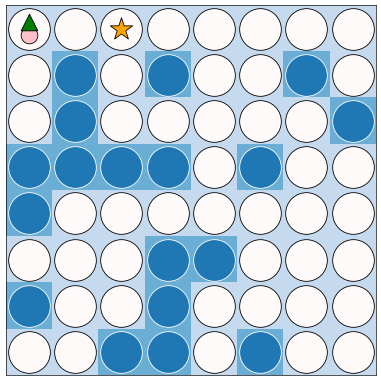

In [6]:
seed = 42
map_scale = 3

max_steps = 2**20
rollout_steps = 4**map_scale
eval_steps = rollout_steps
n_rollouts = max_steps // rollout_steps
batch_size = 8 * rollout_steps

rng_env, rng_sim = jax.random.split(jax.random.PRNGKey(seed))

env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, 0.5)
state, obs = env.reset(rng_env)
plotting.render(env, state)

In [7]:
abs_env = mangoenv.MangoEnv(env)

In [13]:
def train_stage(cell_scale, lower_stage, rng_key):
    rng_init, rng_steps = jax.random.split(rng_key)
    rng_steps = jax.random.split(rng_steps, n_rollouts)

    reward_fn = partial(actions.reward_fn, cell_scale)
    beta_fn = partial(actions.beta_fn, cell_scale)

    qnet = nets.InnerQnet(lower_stage.action_space.n, env.frozen.shape)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_init, qnet, lower_stage, reward_fn=reward_fn, beta_fn=beta_fn
    )

    pbar = tqdm(range(n_rollouts))

    def sim_step(dql_state, rng_key):
        rng_expl, rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
        )
        transitions = utils.random_rollout(env, rng_expl, rollout_steps // 4 ** (cell_scale - 1))
        dql_state = dql_state.update_replay(transitions)

        transitions = dql_state.replay_buffer.sample(rng_train, batch_size)
        transitions = dql_state.process_transitions(transitions)
        dql_state = dql_state.update_params(transitions)

        transitions = dql_state.greedy_rollout(env, rng_eval, eval_steps // 4 ** (cell_scale - 1))
        return dql_state, (transitions.reward, transitions.done)

    dql_state, (rewards, dones) = jax.lax.scan(sim_step, dql_state, rng_steps)
    abs_env = mangoenv.MangoEnv.from_dql_state(lower_stage, dql_state, max_steps=4)

    get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
    plotting.plot_qvals(env, get_qval_fn, tasks=["LEFT", "DOWN", "RIGHT", "UP", "TAKE"])
    
    return abs_env, rewards, dones

In [5]:
abs_env, rewards, dones = train_stage(1, abs_env, rng_sim)

NameError: name 'train_stage' is not defined

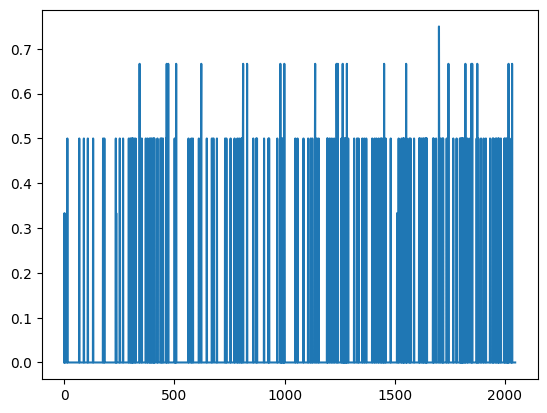

In [ ]:
rewards.shape
import matplotlib.pyplot as plt

def smooth(r, w=1):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")

plt.plot(smooth(rewards.sum(axis=1)/(1+dones.sum(axis=1))))